# Actividad - Proyecto práctico

> La actividad se desarrollará en grupos pre-definidos de 2-3 alumnos. Se debe indicar los nombres en orden alfabético (de apellidos). Recordad que esta actividad se corresponde con un 30% de la nota final de la asignatura. Se debe entregar entregar el trabajo en la presente notebook.
*   Alumno 1: Andrés Solanes, Carles
*   Alumno 2: Barroso Galindo, José Manuel
*   Alumno 3: García González, Nestor
*   Alumno 4: Sánchez López, Roberto





---
## **PARTE 1** - Instalación y requisitos previos


---
### 1.1. Instalar librerías necesarias

In [ ]:
#1. Ejecutar esta celda individualmente
#2. Reiniciar entorno cuando se solicite
#3. Ejecutar desde la siguiente celda en adelante

%pip install gym==0.17.3
%pip install git+https://github.com/Kojoley/atari-py.git
%pip install keras-rl2==1.0.5
%pip install tensorflow==2.12

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 49.4 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.17.3-py3-none-any.whl size=1654617 sha256=b193078a29bb53a4c6b38715950ce131dbe861c17325b2b39fd6caeaae15d67d
  Stored in directory: /root/.cache/pip/wheels/07/8b/b7/570cb90b10f17e85ccb291ba1f04af41ec697745104a2263eb
Successfully built gym
  Attempting uninstall: cloudpickle
    Found existing installation: cloudpickle 3.1.1
    Uninstalling cloudpickle-3.1.1:
      Successfully uninstalled cloudpickle-3.1.1
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask 2024.12.1 requires cloudpickle>

---
### 1.2. Localizar entorno de trabajo

In [ ]:
mount='/content/gdrive'
drive_root = mount + "/My Drive/Colab Notebooks/08_MIAR/actividades/proyecto practico"
from google.colab import drive
IN_COLAB=True


---
### 1.3. Montar carpeta de datos local

In [ ]:
# Switch to the directory on the Google Drive that you want to use
import os
if IN_COLAB:
  print("We're running Colab")

  if IN_COLAB:
    # Mount the Google Drive at mount
    print("Colab: mounting Google drive on ", mount)

    drive.mount(mount)

    # Create drive_root if it doesn't exist
    create_drive_root = True
    if create_drive_root:
      print("\nColab: making sure ", drive_root, " exists.")
      os.makedirs(drive_root, exist_ok=True)

    # Change to the directory
    print("\nColab: Changing directory to ", drive_root)
    %cd $drive_root
# Verify we're in the correct working directory
%pwd
print("Archivos en el directorio: ")
print(os.listdir())

We're running Colab
Colab: mounting Google drive on  /content/gdrive
Mounted at /content/gdrive

Colab: making sure  /content/gdrive/My Drive/Colab Notebooks/08_MIAR/actividades/proyecto practico  exists.

Colab: Changing directory to  /content/gdrive/My Drive/Colab Notebooks/08_MIAR/actividades/proyecto practico
/content/gdrive/My Drive/Colab Notebooks/08_MIAR/actividades/proyecto practico
Archivos en el directorio: 
['dqn_SpaceInvaders-v0_weights_100000.h5f.data-00000-of-00001', 'dqn_SpaceInvaders-v0_weights_100000.h5f.index', 'dqn_SpaceInvaders-v0_weights_200000.h5f.data-00000-of-00001', 'dqn_SpaceInvaders-v0_weights_200000.h5f.index', 'dqn_SpaceInvaders-v0_weights_300000.h5f.data-00000-of-00001', 'dqn_SpaceInvaders-v0_weights_300000.h5f.index', 'dqn_SpaceInvaders-v0_weights_400000.h5f.data-00000-of-00001', 'dqn_SpaceInvaders-v0_weights_400000.h5f.index', 'dqn_SpaceInvaders-v0_weights_500000.h5f.data-00000-of-00001', 'dqn_SpaceInvaders-v0_weights_500000.h5f.index', 'dqn_SpaceInvader

---
## **PARTE 2**. Enunciado

Consideraciones a tener en cuenta:

- El entorno sobre el que trabajaremos será _SpaceInvaders-v0_ y el algoritmo que usaremos será _DQN_.

- Para nuestro ejercicio, el requisito mínimo será alcanzado cuando el agente consiga una **media de recompensa por encima de 20 puntos en modo test**. Por ello, esta media de la recompensa se calculará a partir del código de test en la última celda del notebook.

Este proyecto práctico consta de tres partes:

1.   Implementar la red neuronal que se usará en la solución
2.   Implementar las distintas piezas de la solución DQN
3.   Justificar la respuesta en relación a los resultados obtenidos

**Rúbrica**: Se valorará la originalidad en la solución aportada, así como la capacidad de discutir los resultados de forma detallada. El requisito mínimo servirá para aprobar la actividad, bajo premisa de que la discusión del resultado sera apropiada.

IMPORTANTE:

* Si no se consigue una puntuación óptima, responder sobre la mejor puntuación obtenida.
* Para entrenamientos largos, recordad que podéis usar checkpoints de vuestros modelos para retomar los entrenamientos. En este caso, recordad cambiar los parámetros adecuadamente (sobre todo los relacionados con el proceso de exploración).
* Se deberá entregar unicamente el notebook y los pesos del mejor modelo en un fichero .zip, de forma organizada.
* Cada alumno deberá de subir la solución de forma individual.


---
## **PARTE 3**. Desarrollo y preguntas

#### Importar librerías

In [ ]:
from __future__ import division

from PIL import Image
import numpy as np
import gym

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Convolution2D, Permute, BatchNormalization
from tensorflow.keras.optimizers.legacy import Adam
import tensorflow.keras.backend as K

from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.callbacks import FileLogger, ModelIntervalCheckpoint

#### Configuración base

In [ ]:
INPUT_SHAPE = (84, 84)
WINDOW_LENGTH = 4

env_name = 'SpaceInvaders-v0'
env = gym.make(env_name)

np.random.seed(123)
env.seed(123)
nb_actions = env.action_space.n

In [ ]:
class AtariProcessor(Processor):
    def process_observation(self, observation):
        assert observation.ndim == 3  # (height, width, channel)
        img = Image.fromarray(observation)
        img = img.resize(INPUT_SHAPE).convert('L')
        processed_observation = np.array(img)
        assert processed_observation.shape == INPUT_SHAPE
        return processed_observation.astype('uint8')

    def process_state_batch(self, batch):
        processed_batch = batch.astype('float32') / 255.
        return processed_batch

    def process_reward(self, reward):
        return np.clip(reward, -1., 1.)

#### 1. Implementación de la red neuronal

Para implementar el algoritmo de DQN es necesario definir una estructura con la que el agente analiza la información del entorno y después decidir la acción a aplicar en ese momento. Esta estructura es una red neuronal y funciona como si fuese el "cerebro" del agente. Hemos planteado una red neuronal con 15 capas divididas en 7 bloques funcionales, cada uno con un propósito específico, y los cuales describimos en la siguiente tabla

| Bloque Nº | Nombre del bloque               | Capas incluidas                                                  | Descripción del bloque                                                                                                                                      |
|-----------|----------------------------------|------------------------------------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------|
| 0         | Capa de entrada                 | `Permute`                                                        | Reorganiza los ejes de la entrada de (frames, alto, ancho) a (alto, ancho, frames) para que puedan ser procesados por capas convolucionales.               |
| 1         | Primer bloque convolucional     | `Conv2D(32, 8x8, stride 4)` + `BatchNormalization` + `ReLU`      | Detecta patrones visuales grandes como posiciones generales del jugador o grupos de enemigos.                                                              |
| 2         | Segundo bloque convolucional    | `Conv2D(64, 4x4, stride 2)` + `BatchNormalization` + `ReLU`      | Extrae detalles más finos y localizados, útil para detectar movimientos u objetos más pequeños.                                                            |
| 3         | Tercer bloque convolucional     | `Conv2D(64, 3x3, stride 1)` + `BatchNormalization` + `ReLU`      | Captura características visuales muy específicas, como proyectiles, colisiones o pequeñas variaciones del entorno.                                         |
| 4         | Aplanado de características     | `Flatten`                                                        | Convierte los mapas de activación tridimensionales en un vector plano, necesario para conectar con las capas densas.                                       |
| 5         | Capa densa intermedia           | `Dense(512)` + `ReLU`                                            | Crea una representación abstracta de alto nivel del estado del entorno, sintetizando toda la información visual extraída previamente.                     |
| 6         | Capa de salida                  | `Dense(nb_actions)` + `Activation('linear')`                    | Genera un valor Q estimado por cada acción posible. Estos valores son usados por el agente para decidir su comportamiento en el entorno.                   |


Como se puede observar se define una red de 7 bloques funcionales. Se puede decir que los bloques 0 - 4 conforman la parte de extracción de características (o procesado), y los bloques 5 y 6 contienen las capas en las que se hace la decisión (o interpretación y salida).

El siguiente fragmento de código define la red neuronal en Python

In [ ]:
model = Sequential()

# Bloque 0 - Capa de entrada
model.add(Permute((2, 3, 1), input_shape=(WINDOW_LENGTH,) + INPUT_SHAPE))

# Bloque 1 - Primer bloque convolucional: Detección de objetos grandes
model.add(Convolution2D(32, (8, 8), strides=(4, 4)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# Bloque 2 - Segundo bloque convolucional: Detección de detalles finos y localizados
model.add(Convolution2D(64, (4, 4), strides=(2, 2)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# Bloque 3 - Tercer bloque convolucional: Características visuales muy específicas
model.add(Convolution2D(64, (3, 3), strides=(1, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# Bloque 4 - Aplanado de características
model.add(Flatten())

# Bloque 5 - Capa densa intermedia
model.add(Dense(512))
model.add(Activation('relu'))

# Bloque 6 - Capa de salida
model.add(Dense(nb_actions))
model.add(Activation('linear'))

Instructions for updating:
Colocations handled automatically by placer.


#### 2. Implementación de la solución DQN

##### **Bloque 1 de ejecución**

El objetivo de este bloque de ejecución es que el agente aprenda a jugar al de manera autónoma, de tal manera que las decisiones que toma son más acertadas a medida que gana experiencia. Los parámetros más relevantes de la implementación de nuestra solución DQN son los siguientes:

*   **Memoria:**
    -   `limit`: 1.000.000 -> Tamaño máximo del buffer de experiencia
    -   `window_length`: 4 -> Número de frames por estado

*   **Exploración:** Política $\varepsilon$-greedy con decaimiento lineal. DE 1 hata 0.1 en 1.000.000 de pasos
    -   `epsilon inicial`:1.0
    -   `minimo`: 0.1
    -   `evaluación`: 0.05
    -   Decrece durante 1.000.000 de pasos

*   **Agente:**
    -   `nb_actions`: Número de acciones sin entorno -> En SpaceInvaders 6
    -   `warmup`: 50.000 -> Pasos sin entrenamiento (Calentamiento)
    -   `gamma`: 0.99 -> Descuento para recompensas futuras
    -   `target_model_update`: 10.000 -> Frecuencia de actualización de la red objetivo
    -   `train_interval`: 4 -> entrenamiento cada 4 pasos
    -   `delta_clip`: 1.0 -> Límite para evitar gradientes extremos

*   **Compilación:**
    -   Optimizador: Adam con lr=0.00025
    -   Métrica: MAE -> Error absoluto medio

*   **Entrenamiento:**
    -   `nb_steps`:1.750.000 -> pasos totales del entrenamiento
    -   Callbacks: guardado de pesos cada 100.000 pasos y logs de métricas periódicas


Tras definir estos parámetros este sería el código que implementa la solución:




In [ ]:
# Memoria de experiencia (Replay Memory)
# Almacena memorias de estados para que le agente pueda aprender de experiencias pasadas
memory = SequentialMemory(limit=1000000, window_length=WINDOW_LENGTH)

# Política de exploración: (Epsilon)-Greedy con decaimiento lineal
# Controla cuánto explora el agente frente a cuánto explora lo aprendido
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps',
                              value_max=1., value_min=.1, value_test=.05,
                              nb_steps=1000000)

# Definición del agente DQN
# Se integra la red neuronal, la política, la memoria y los parámetros clave del entrenamiento
dqn = DQNAgent(model=model, nb_actions=nb_actions, policy=policy,
               memory=memory, processor=AtariProcessor(),
               nb_steps_warmup=50000, gamma=.99, target_model_update=10000,
               train_interval=4, delta_clip=1.)

# Compilación del agente con optimizador Adam y métrica MAE
dqn.compile(Adam(learning_rate=0.00025), metrics=['mae'])

# Directorio donde guardar los archivos de checkpoints
weights_prefix = f'/{drive_root}/dqn_{env_name}_weights'

# Callback para guardar los checkpoints, con número de pasos definidos en interval
checkpoint_callback = ModelIntervalCheckpoint(weights_prefix + '_{step}.h5f', interval=100000)

# Callback para logs de entrenamiento
log_filename = f'/{drive_root}/dqn_{env_name}_log.json'
log_callback = FileLogger(log_filename, interval=100)

# Lista de callbacks que se aplicarán
callbacks = [checkpoint_callback, log_callback]

# Entrenamiento del agente
dqn.fit(env, nb_steps=1750000, visualize=False, verbose=2, callbacks=callbacks)

# Guardado finalo de los pesos del modelo entrenado
final_weights = f'/{drive_root}/dqn_{env_name}_weights_final.h5f'
dqn.save_weights(final_weights, overwrite=True)


Training for 1750000 steps ...


/usr/local/lib/python3.11/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


     514/1750000: episode: 1, duration: 2.514s, episode steps: 514, steps per second: 204, episode reward:  1.000, mean reward:  0.002 [ 0.000,  1.000], mean action: 2.473 [0.000, 5.000],  loss: --, mae: --, mean_q: --, mean_eps: --
    1068/1750000: episode: 2, duration: 2.441s, episode steps: 554, steps per second: 227, episode reward:  7.000, mean reward:  0.013 [ 0.000,  1.000], mean action: 2.356 [0.000, 5.000],  loss: --, mae: --, mean_q: --, mean_eps: --
    1612/1750000: episode: 3, duration: 2.399s, episode steps: 544, steps per second: 227, episode reward:  7.000, mean reward:  0.013 [ 0.000,  1.000], mean action: 2.568 [0.000, 5.000],  loss: --, mae: --, mean_q: --, mean_eps: --
    2311/1750000: episode: 4, duration: 3.069s, episode steps: 699, steps per second: 228, episode reward:  9.000, mean reward:  0.013 [ 0.000,  1.000], mean action: 2.559 [0.000, 5.000],  loss: --, mae: --, mean_q: --, mean_eps: --
    2915/1750000: episode: 5, duration: 2.671s, episode steps: 604, 

/usr/local/lib/python3.11/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


   50558/1750000: episode: 77, duration: 20.100s, episode steps: 1057, steps per second:  53, episode reward: 14.000, mean reward:  0.013 [ 0.000,  1.000], mean action: 2.584 [0.000, 5.000],  loss: 0.094151, mae: 0.288254, mean_q: 0.518568, mean_eps: 0.954748
   51067/1750000: episode: 78, duration: 15.057s, episode steps: 509, steps per second:  34, episode reward:  9.000, mean reward:  0.018 [ 0.000,  1.000], mean action: 2.536 [0.000, 5.000],  loss: 0.014675, mae: 0.112392, mean_q: 0.223279, mean_eps: 0.954269
   51831/1750000: episode: 79, duration: 22.729s, episode steps: 764, steps per second:  34, episode reward:  7.000, mean reward:  0.009 [ 0.000,  1.000], mean action: 2.541 [0.000, 5.000],  loss: 0.010021, mae: 0.086086, mean_q: 0.177780, mean_eps: 0.953697
   52652/1750000: episode: 80, duration: 24.415s, episode steps: 821, steps per second:  34, episode reward: 13.000, mean reward:  0.016 [ 0.000,  1.000], mean action: 2.560 [0.000, 5.000],  loss: 0.008015, mae: 0.070830, 

##### **Bloque 1: Resultados**
**//TO-DO: REVISAR ESTA SECCIÓN**


Lanzamos el test para los 17 checkpoints intermedios que se han guardado. Observamos que aunque hay episodios con puntaciones más latas, los resultados no mejoran de forma progresiva, si no que hay altibajos. Esto se puede explicar porque en entornos complejos como Space Invader, hay una componente estocástica, es decir, que en el propio entorno de la simulación hay un componente de azar. También podria explicarse porque lo habitual en DQN es que el agente necesite cientos de miles de pasos para estabilizarse y el nivel de epsilon continúe alto, lo que significa que el agente no ha terminado la exploración. En cualquier caso, el balanceo de datos es un comportamiento esperable durante la fase de exploración y el entrenamiento temprano.

Analizando los resultados obtenidos observamos que el entrenamiento número 13 es el que mejores resultados ha dado. Esto puede suponer que, por azar, el agente ha tomado una buena secuencia de decisiones, se haya beneficiado de una configuración favorable del entorno, o simplemente haya acertado con la política aplicada sin haber aprendido del todo. Todo esto, sumado al balanceo de datos, podría explicar que la exploración haya dado buenos resultados en este episodio pero luego en los siguientes no se hayan vuelto a alcanzar esas puntuaciones.

In [ ]:
for steps in range(100000, 1700001, 100000):
    weights_file = f'/{drive_root}/dqn_{env_name}_weights_{steps}.h5f'
    print(f"Cargando pesos de: {weights_file}")
    dqn.load_weights(weights_file)
    print(f"Test en el entorno con pesos de paso {steps}:")
    dqn.test(env, nb_episodes=10, visualize=False)

Cargando pesos de: //content/gdrive/My Drive/Colab Notebooks/08_MIAR/actividades/proyecto practico/dqn_SpaceInvaders-v0_weights_100000.h5f
Test en el entorno con pesos de paso 100000:
Testing for 10 episodes ...
Episode 1: reward: 0.000, steps: 510
Episode 2: reward: 0.000, steps: 505
Episode 3: reward: 0.000, steps: 509
Episode 4: reward: 0.000, steps: 501
Episode 5: reward: 0.000, steps: 502
Episode 6: reward: 0.000, steps: 507
Episode 7: reward: 0.000, steps: 501
Episode 8: reward: 0.000, steps: 505
Episode 9: reward: 0.000, steps: 499
Episode 10: reward: 0.000, steps: 502
Cargando pesos de: //content/gdrive/My Drive/Colab Notebooks/08_MIAR/actividades/proyecto practico/dqn_SpaceInvaders-v0_weights_200000.h5f
Test en el entorno con pesos de paso 200000:
Testing for 10 episodes ...
Episode 1: reward: 10.000, steps: 532
Episode 2: reward: 11.000, steps: 662
Episode 3: reward: 11.000, steps: 523
Episode 4: reward: 9.000, steps: 371
Episode 5: reward: 11.000, steps: 1393
Episode 6: rewa

Lanzamos el test para el checkpoint final.

Vemos que los resultados obtenidos son peores que los del punto de guardado 13.

In [ ]:
# Testing part to calculate the mean reward
final_weights = f'/{drive_root}/dqn_{env_name}_weights_final.h5f'
dqn.load_weights(final_weights)
dqn.test(env, nb_episodes=10, visualize=False)

Testing for 10 episodes ...
Episode 1: reward: 18.000, steps: 718
Episode 2: reward: 18.000, steps: 718
Episode 3: reward: 18.000, steps: 719
Episode 4: reward: 18.000, steps: 720
Episode 5: reward: 18.000, steps: 710
Episode 6: reward: 18.000, steps: 717
Episode 7: reward: 18.000, steps: 714
Episode 8: reward: 18.000, steps: 703
Episode 9: reward: 18.000, steps: 733
Episode 10: reward: 18.000, steps: 714


##### **Bloque 2 de ejecución**

En este bloque lo que intentamos conseguir es afinar el modelo previamente entrenado. Estos son los parámetros con los que hemos configurado el modelo:
*   **Memoria:**
    -   `limit`: 100.000 -> Tamaño máximo de buffer (Más pequeño que el bloque 1)
    -   `window_length`: 4 -> Número de frames por estado

*   **Exploración:** Política $\varepsilon$-greedy con decaimiento lineal. De 0.1 hasta 00.1 en 1.000.000 de pasos
    -   `epsilon inicial`:1.0
    -   `epsilon final`: 0.01
    -   `evaluación`: 0.05
    -   Decrece durante 100.000 pasos

*   **Agente:**
    -   `warmup`: 1.000 -> Pasos sin entrenamiento (Calentamiento). Más pequeño que el bloque 1
    -   `gamma`: 0.99 -> Descuento para recompensas futuras
    -   `target_model_update`: 10.000 -> Frecuencia de actualización de la red objetivo
    -   `train_interval`: 4 -> entrenamiento cada 4 pasos
    -   `delta_clip`: 1.0 -> Límite para evitar gradientes extremos

*   **Compilación:**
    -   Optimizador: Adam con lr=0.00025
    -   Métrica: MAE -> Error absoluto medio

*   **Entrenamiento:**
    -   `nb_steps`:500.000 -> pasos totales del entrenamiento. Más pequeño que en el bloque 1
    -   Callbacks: guardado de pesos cada 100.000 pasos y logs de métricas periódicas
    -   Reanuda desde el checkpoint que mejores datos ha dado en el bloque 1.


In [ ]:
# Replay Buffer
# Almacena un máximo de 100.000 transiciones con una longitud de ventana de 4 frames
memory = SequentialMemory(limit=100_000, window_length=WINDOW_LENGTH)

# Política E(epsilon)-greedy con menor exploración
# El agente comienza explorando poco (epsilon=0.1) y reduce a 0.01 en 100.000 pasos.
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps',
                              value_max=.1, value_min=.01, value_test=.05,
                              nb_steps=100_000)

# Definición y configuración del agente DQN
dqn = DQNAgent(model=model, nb_actions=nb_actions, policy=policy,
               memory=memory, processor=AtariProcessor(),
               nb_steps_warmup=1_000, gamma=.99, target_model_update=10000,
               train_interval=4, delta_clip=1.)

# Compilación con optimizador Adam y métrica MAE
dqn.compile(Adam(learning_rate=0.00025), metrics=['mae'])

# Directorio donde guardar los archivos
weights_prefix = f'/{drive_root}/dqn2_{env_name}_weights'

# Callback para guardar cada 100.000 pasos
checkpoint_callback = ModelIntervalCheckpoint(weights_prefix + '_{step}.h5f', interval=100000)

# Callback para logs de entrenamiento
log_filename = f'/{drive_root}/dqn2_{env_name}_log.json'
log_callback = FileLogger(log_filename, interval=100)

# Lista de callbacks
callbacks = [checkpoint_callback, log_callback]

# Reanudar desde un checkpoint
dqn.load_weights('dqn_SpaceInvaders-v0_weights_1300000.h5f')

# Entrenamiento del modelo
dqn.fit(env, nb_steps=500_000, visualize=False, verbose=2, callbacks=callbacks)

# Guardar pesos finales
final_weights = f'/{drive_root}/dqn2_{env_name}_weights_final.h5f'
dqn.save_weights(final_weights, overwrite=True)


Training for 500000 steps ...


/usr/local/lib/python3.11/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


    705/500000: episode: 1, duration: 4.102s, episode steps: 705, steps per second: 172, episode reward: 20.000, mean reward:  0.028 [ 0.000,  1.000], mean action: 3.138 [0.000, 5.000],  loss: --, mae: --, mean_q: --, mean_eps: --


/usr/local/lib/python3.11/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


   1995/500000: episode: 2, duration: 49.139s, episode steps: 1290, steps per second:  26, episode reward: 20.000, mean reward:  0.016 [ 0.000,  1.000], mean action: 2.629 [0.000, 5.000],  loss: 0.012889, mae: 1.634471, mean_q: 1.968285, mean_eps: 0.098652
   2644/500000: episode: 3, duration: 29.950s, episode steps: 649, steps per second:  22, episode reward: 15.000, mean reward:  0.023 [ 0.000,  1.000], mean action: 3.103 [0.000, 5.000],  loss: 0.011301, mae: 1.593574, mean_q: 1.913363, mean_eps: 0.097914
   3597/500000: episode: 4, duration: 45.792s, episode steps: 953, steps per second:  21, episode reward: 12.000, mean reward:  0.013 [ 0.000,  1.000], mean action: 2.472 [0.000, 5.000],  loss: 0.013076, mae: 1.652309, mean_q: 1.985538, mean_eps: 0.097192
   5324/500000: episode: 5, duration: 80.963s, episode steps: 1727, steps per second:  21, episode reward: 16.000, mean reward:  0.009 [ 0.000,  1.000], mean action: 2.840 [0.000, 5.000],  loss: 0.010866, mae: 1.684888, mean_q: 2.0

##### **Bloque 2: Resultados**

Lanzamos el test para los 5 checkpoints intermedios que se han guardado.

Vemos que el número 1 es el que mejores resultados ha obtenido.

In [ ]:
for steps in range(100000, 500001, 100000):
    weights_file = f'/{drive_root}/dqn2_{env_name}_weights_{steps}.h5f'
    print(f"Cargando pesos de: {weights_file}")
    dqn.load_weights(weights_file)
    print(f"Test en el entorno con pesos de paso {steps}:")
    dqn.test(env, nb_episodes=10, visualize=False)

Cargando pesos de: //content/gdrive/My Drive/Colab Notebooks/08_MIAR/actividades/proyecto practico/dqn2_SpaceInvaders-v0_weights_100000.h5f
Test en el entorno con pesos de paso 100000:
Testing for 10 episodes ...


/usr/local/lib/python3.11/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Episode 1: reward: 20.000, steps: 771
Episode 2: reward: 23.000, steps: 1199
Episode 3: reward: 22.000, steps: 824
Episode 4: reward: 21.000, steps: 943
Episode 5: reward: 27.000, steps: 1153
Episode 6: reward: 19.000, steps: 799
Episode 7: reward: 18.000, steps: 1233
Episode 8: reward: 12.000, steps: 650
Episode 9: reward: 16.000, steps: 616
Episode 10: reward: 17.000, steps: 820
Cargando pesos de: //content/gdrive/My Drive/Colab Notebooks/08_MIAR/actividades/proyecto practico/dqn2_SpaceInvaders-v0_weights_200000.h5f
Test en el entorno con pesos de paso 200000:
Testing for 10 episodes ...
Episode 1: reward: 6.000, steps: 951
Episode 2: reward: 6.000, steps: 934
Episode 3: reward: 6.000, steps: 704
Episode 4: reward: 5.000, steps: 944
Episode 5: reward: 4.000, steps: 937
Episode 6: reward: 4.000, steps: 950
Episode 7: reward: 6.000, steps: 935
Episode 8: reward: 6.000, steps: 929
Episode 9: reward: 10.000, steps: 932
Episode 10: reward: 4.000, steps: 947
Cargando pesos de: //content/gd

Lanzamos también el test para el guardado de pesos final, con 100 ejecuciones y media:

**Media de recompensas: 19.41**

In [ ]:
weights_file = f'/{drive_root}/dqn2_{env_name}_weights_100000.h5f'
print(f"Cargando pesos de: {weights_file}")
dqn.load_weights(weights_file)

# Ejecutar test y guardar los resultados
hist = dqn.test(env, nb_episodes=100, visualize=False)

# Acceder a las recompensas de los episodios
recompensas = hist.history['episode_reward']

# Calcular la media
media = sum(recompensas) / len(recompensas)

# Mostrar la media
print("Media de recompensas:", media)

Cargando pesos de: //content/gdrive/My Drive/Colab Notebooks/08_MIAR/actividades/proyecto practico/dqn2_SpaceInvaders-v0_weights_100000.h5f
Testing for 100 episodes ...
Episode 1: reward: 19.000, steps: 922
Episode 2: reward: 16.000, steps: 1132
Episode 3: reward: 17.000, steps: 731
Episode 4: reward: 16.000, steps: 615
Episode 5: reward: 22.000, steps: 898
Episode 6: reward: 23.000, steps: 1454
Episode 7: reward: 22.000, steps: 906
Episode 8: reward: 17.000, steps: 1215
Episode 9: reward: 13.000, steps: 700
Episode 10: reward: 19.000, steps: 659
Episode 11: reward: 13.000, steps: 651
Episode 12: reward: 19.000, steps: 790
Episode 13: reward: 20.000, steps: 887
Episode 14: reward: 16.000, steps: 629
Episode 15: reward: 13.000, steps: 494
Episode 16: reward: 23.000, steps: 1178
Episode 17: reward: 16.000, steps: 599
Episode 18: reward: 28.000, steps: 1450
Episode 19: reward: 18.000, steps: 805
Episode 20: reward: 21.000, steps: 826
Episode 21: reward: 20.000, steps: 1214
Episode 22: rew

##### **Bloque 3 de ejecución**
En este último bloque, vamos a intentar hacer un ajuste todavía más fino del modelo. Para ello definimos los siguientes parámetros

*   **Memoria:**
    -   `limit`: 100.000 -> Tamaño máximo de buffer
    -   `window_length`: 4 -> Número de frames por estado

*   **Exploración:** Política $\varepsilon$-greedy con decaimiento lineal. De 0.1 hasta 00.1 en 1.000.000 de pasos
    -   `epsilon inicial`:1.0
    -   `epsilon final`: 0.01
    -   `evaluación`: 0.05
    -   Decrece durante 100.000 pasos

*   **Agente:**
    -   `warmup`: 1.000 -> Pasos sin entrenamiento (Calentamiento).
    -   `gamma`: 0.99 -> Descuento para recompensas futuras
    -   `target_model_update`: 10.000 -> Frecuencia de actualización de la red objetivo
    -   `train_interval`: 4 -> entrenamiento cada 4 pasos
    -   `delta_clip`: 1.0 -> Límite para evitar gradientes extremos

*   **Compilación:**
    -   Optimizador: Adam con lr=0.00025
    -   Métrica: MAE -> Error absoluto medio

*   **Entrenamiento:**
    -   `nb_steps`:100.000 -> pasos totales del entrenamiento. Menos pasos que en bloque 2
    -   Callbacks: guardado de pesos cada 100.000 pasos y logs de métricas periódicas
    -   Reanuda desde checkpoint. En este caso tomamos como origine el mejor checkpoint de datos del bloque 2

Prácticamente la parametrización de este bloque es la misma que en bloque 2. Tan solo cambia el número de pasos de ejecución que pasan de 500.000 a 100.000


In [ ]:
# Replay Buffer
# Guarda hasta 100.000 transiciones, con una ventana de 4 frames por entrada.
memory = SequentialMemory(limit=100_000, window_length=WINDOW_LENGTH)

# Política de exploración Epsilon-greedy
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps',
                              value_max=.1, value_min=.01, value_test=.05,
                              nb_steps=100_000)

# Definición del agente DQN
dqn = DQNAgent(model=model, nb_actions=nb_actions, policy=policy,
               memory=memory, processor=AtariProcessor(),
               nb_steps_warmup=1_000, gamma=.99, target_model_update=10000,
               train_interval=4, delta_clip=1.)

# Compilación del agente con optimizador Adam y métrica MAE
dqn.compile(Adam(learning_rate=0.00025), metrics=['mae'])

# Directorio donde guardar los archivos
weights_prefix = f'/{drive_root}/dqn3_{env_name}_weights'

# Callback para guardar cada 100.000 pasos
checkpoint_callback = ModelIntervalCheckpoint(weights_prefix + '_{step}.h5f', interval=100000)

# Callback para logs de entrenamiento
log_filename = f'/{drive_root}/dqn3_{env_name}_log.json'
log_callback = FileLogger(log_filename, interval=100)

# Lista de callbacks
callbacks = [checkpoint_callback, log_callback]

# Reanudar desde un checkpoint
dqn.load_weights('dqn2_SpaceInvaders-v0_weights_100000.h5f')

# Entrenamiento del modelo
dqn.fit(env, nb_steps=100_000, visualize=False, verbose=2, callbacks=callbacks)

# Guardar pesos finales
final_weights = f'/{drive_root}/dqn3_{env_name}_weights_final.h5f'
dqn.save_weights(final_weights, overwrite=True)


Training for 100000 steps ...


/usr/local/lib/python3.11/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


   874/100000: episode: 1, duration: 4.328s, episode steps: 874, steps per second: 202, episode reward: 19.000, mean reward:  0.022 [ 0.000,  1.000], mean action: 3.593 [0.000, 5.000],  loss: --, mae: --, mean_q: --, mean_eps: --


/usr/local/lib/python3.11/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


  1681/100000: episode: 2, duration: 30.872s, episode steps: 807, steps per second:  26, episode reward: 14.000, mean reward:  0.017 [ 0.000,  1.000], mean action: 3.260 [0.000, 5.000],  loss: 0.014640, mae: 1.709653, mean_q: 2.058606, mean_eps: 0.098792
  2205/100000: episode: 3, duration: 21.199s, episode steps: 524, steps per second:  25, episode reward: 10.000, mean reward:  0.019 [ 0.000,  1.000], mean action: 3.645 [0.000, 5.000],  loss: 0.013424, mae: 1.740480, mean_q: 2.091952, mean_eps: 0.098250
  3520/100000: episode: 4, duration: 51.610s, episode steps: 1315, steps per second:  25, episode reward: 20.000, mean reward:  0.015 [ 0.000,  1.000], mean action: 3.741 [0.000, 5.000],  loss: 0.010232, mae: 1.713918, mean_q: 2.067500, mean_eps: 0.097424
  4144/100000: episode: 5, duration: 24.708s, episode steps: 624, steps per second:  25, episode reward: 14.000, mean reward:  0.022 [ 0.000,  1.000], mean action: 3.462 [0.000, 5.000],  loss: 0.012044, mae: 1.664095, mean_q: 2.006045

##### **Bloque 3: Resultados**

Lanzamos el test para 100 ejecuciones y realizamos la media.

**Media de recompensas: 22.38**

In [ ]:
weights_file = f'/{drive_root}/dqn3_{env_name}_weights_final.h5f'
print(f"Cargando pesos de: {weights_file}")
dqn.load_weights(weights_file)

# Ejecutar test y guardar los resultados
hist = dqn.test(env, nb_episodes=100, visualize=False)

# Acceder a las recompensas de los episodios
recompensas = hist.history['episode_reward']

# Calcular la media
media = sum(recompensas) / len(recompensas)

# Mostrar la media
print("Media de recompensas:", media)

Cargando pesos de: //content/gdrive/My Drive/Colab Notebooks/08_MIAR/actividades/proyecto practico/dqn3_SpaceInvaders-v0_weights_final.h5f
Testing for 100 episodes ...
Episode 1: reward: 23.000, steps: 944
Episode 2: reward: 23.000, steps: 930
Episode 3: reward: 23.000, steps: 917
Episode 4: reward: 23.000, steps: 917
Episode 5: reward: 19.000, steps: 824
Episode 6: reward: 23.000, steps: 928
Episode 7: reward: 23.000, steps: 941
Episode 8: reward: 23.000, steps: 937
Episode 9: reward: 20.000, steps: 810
Episode 10: reward: 23.000, steps: 938
Episode 11: reward: 23.000, steps: 922
Episode 12: reward: 21.000, steps: 926
Episode 13: reward: 23.000, steps: 927
Episode 14: reward: 23.000, steps: 936
Episode 15: reward: 20.000, steps: 809
Episode 16: reward: 23.000, steps: 943
Episode 17: reward: 23.000, steps: 920
Episode 18: reward: 23.000, steps: 937
Episode 19: reward: 23.000, steps: 950
Episode 20: reward: 23.000, steps: 945
Episode 21: reward: 16.000, steps: 1106
Episode 22: reward: 2

#### 3. Justificación de los parámetros seleccionados y de los   obtenidos

---

//TODO: Graficar todas las métricas de que dispongamos

// Igual queda bien concatenar las 3 ejecuciones desde el punto donde se retoma de la ejecución anterior

// Para las métricas de rewards, además de poner el valor en cada punto, igual sería interesante poner la media histórica con una ventana de X ejecuciones, para que se vea la evolución de los valores medios en el tiempo (si no, no se ve nada con tanta varianza)



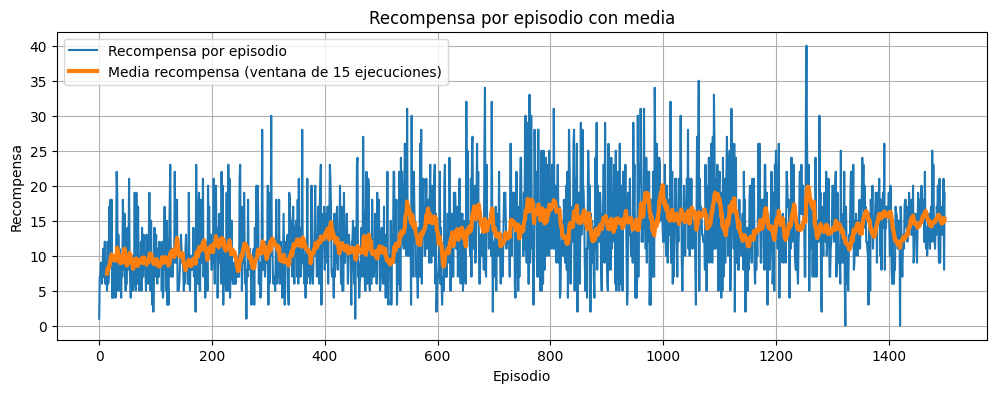

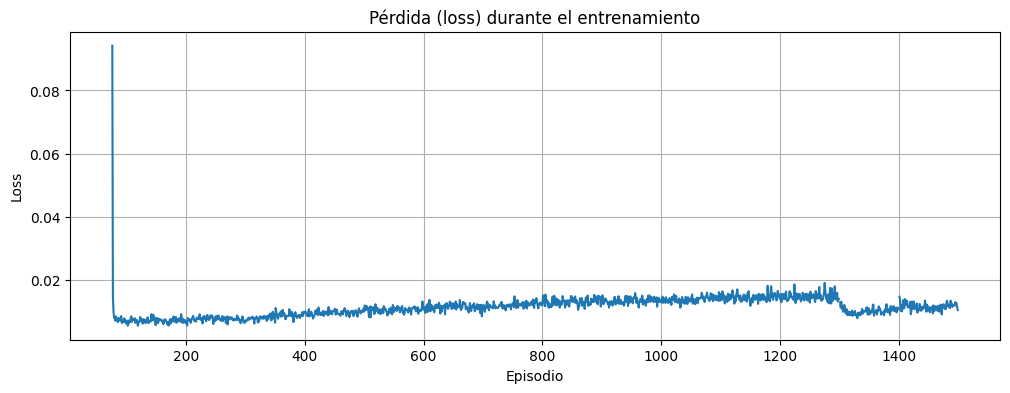

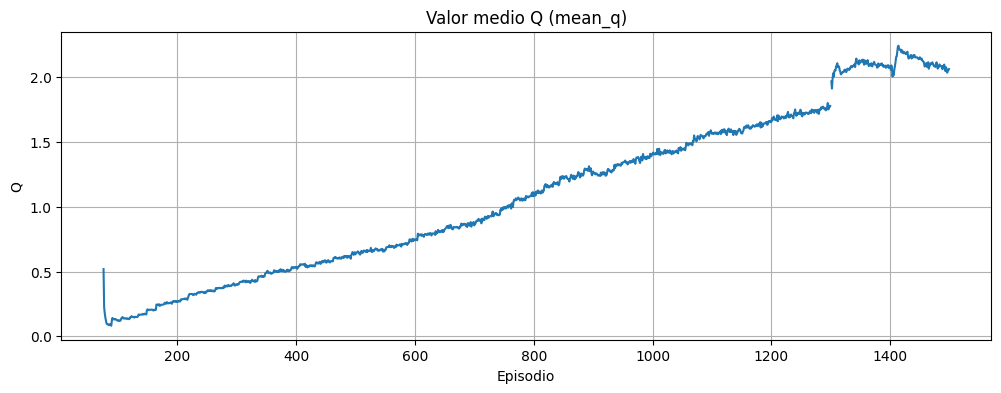

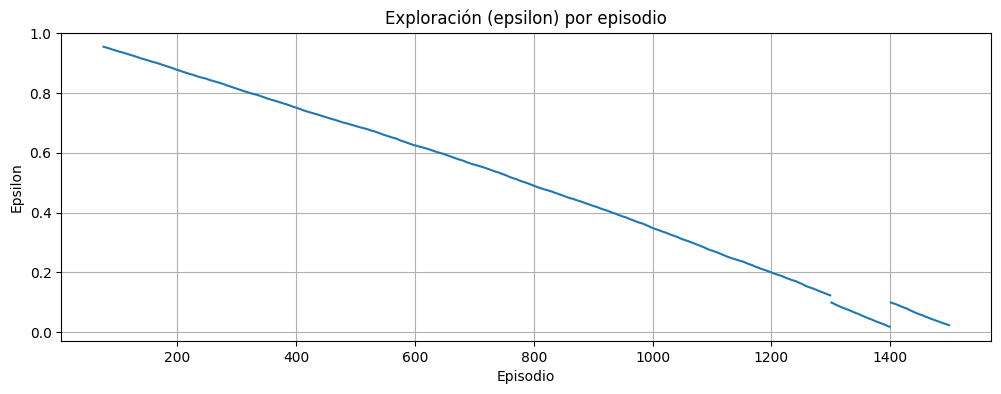

In [5]:
import json
import matplotlib.pyplot as plt
import pandas as pd

# Nombres archivos log y episodio checkpoint
archivos_log = [
    (f'dqn_{env_name}_log.json', 1300),
    (f'dqn2_{env_name}_log.json', 100),
    (f'dqn3_{env_name}_log.json', 100),
]

rewards, losses, mean_qs, mean_eps, media_rewards = [], [], [], [], []

for archivo_log, checkpoint in archivos_log:
    # Ruta al archivo log en Google Drive
    log_path = os.path.join(drive_root, archivo_log)
    # Cargar los datos del archivo JSON
    with open(log_path, 'r') as f:
        history = json.load(f)

    # Extraer métricas
    losses += history.get('loss', [])[:checkpoint]
    mean_qs += history.get('mean_q', [])[:checkpoint]
    mean_eps += history.get('mean_eps', [])[:checkpoint]
    rewards += history['episode_reward'][:checkpoint]

    # Para rewards calculamos la media con una ventana de X ejecuciones
    # y que se vea mejor la evolución, sin tanta varianza
    X = 15
    # Se calcula la media móvil con ventana deslizante de rewards
    media_rewards = pd.Series(rewards).rolling(window=X).mean().tolist()


# Gráfica de recompensas
plt.figure(figsize=(12, 4))
plt.plot(rewards, label='Recompensa por episodio')
plt.plot(media_rewards, label=f'Media recompensa (ventana de {X} ejecuciones)', linewidth=3)
plt.title('Recompensa por episodio con media')
plt.xlabel('Episodio')
plt.ylabel('Recompensa')
plt.legend()
plt.grid(True)
plt.show()

# Gráfica de pérdida si está disponible
if losses:
    plt.figure(figsize=(12, 4))
    plt.plot(losses)
    plt.title('Pérdida (loss) durante el entrenamiento')
    plt.xlabel('Episodio')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

# Gráfica de mean_q
if mean_qs:
    plt.figure(figsize=(12, 4))
    plt.plot(mean_qs)
    plt.title('Valor medio Q (mean_q)')
    plt.xlabel('Episodio')
    plt.ylabel('Q')
    plt.grid(True)
    plt.show()

# Gráfica de epsilon
if mean_eps:
    plt.figure(figsize=(12, 4))
    plt.plot(mean_eps)
    plt.title('Exploración (epsilon) por episodio')
    plt.xlabel('Episodio')
    plt.ylabel('Epsilon')
    plt.grid(True)
    plt.show()

//TODO: Incluir video o videos de varias ejecuciones


//TODO: Resumen final del notebook y justificación general